In [1]:
"""
https://www.kaggle.com/bk0000/non-blending-lightgbm-model-lb-0-977

A non-blending lightGBM model that incorporates portions and ideas from various public kernels
This kernel gives LB: 0.977 when the parameter 'debug' below is set to 0 but this implementation requires a machine with ~32 GB of memory
"""

import datetime
import pandas as pd
import time
import numpy as np
from sklearn.cross_validation import train_test_split
import lightgbm as lgb
import gc
import matplotlib.pyplot as plt
import os

debug=0
if debug:
    print('*** debug parameter set: this is a test run for debugging purposes ***')

    
def add_x5(df, group, group_name, len_train, len_val): 
    """
    1) take a group X, calculate K:=count() and A:=sum(is_attributed) for the group
    2) join this information both to your train set and validation set
    3) for each row calculate likelihood (A - is_attributed)/(K-1) (take care as K-1 can be zero), where is_attributed is the target value for the train/val row.
    4) add some small random noise if you wish

    For test set, 3) can be replace by simply A/K + some noise if you wish
    """    

    k_df = df.iloc[(len_train-len_val):len_train]
    #k_df = df.sample(frac=0.1)
    group_object = k_df.groupby(group)
    K = group_object['is_attributed'].count().reset_index().rename(index=str, columns={'is_attributed': 'K'})
    A = group_object['is_attributed'].sum().reset_index().rename(index=str, columns={'is_attributed': 'A'})
    print('==K')
    print(K.describe())
    
    print('==A')
    print(A.describe())
    
    out = df.merge(K, on=group, how='left')
    out = out.merge(A, on=group, how='left')
    
    out[group_name] = 0    
    out[group_name] = out.A / (out.K+1e-9) # for test rows
    #out.loc[:len_train, group_name] = (out.loc[:len_train, 'A'] - out.loc[:len_train, 'is_attributed']) / (out.loc[:len_train, 'K'] - 1)
    
    df[group_name] = out[group_name]
    
    print('====')
    print(df[group_name].describe())
    return df
    


def lgb_modelfit_nocv(params, dtrain, dvalid, predictors, target='target', objective='binary', metrics='auc',
                 feval=None, early_stopping_rounds=20, num_boost_round=3000, verbose_eval=10, categorical_features=None):
    lgb_params = {
        'boosting_type': 'gbdt',
        'objective': objective,
        'metric':metrics,
        'learning_rate': 0.2,
        #'is_unbalance': 'true',  #because training data is unbalance (replaced with scale_pos_weight)
        'num_leaves': 31,  # we should let it be smaller than 2^(max_depth)
        'max_depth': -1,  # -1 means no limit
        'min_child_samples': 20,  # Minimum number of data need in a child(min_data_in_leaf)
        'max_bin': 255,  # Number of bucketed bin for feature values
        'subsample': 0.6,  # Subsample ratio of the training instance.
        'subsample_freq': 0,  # frequence of subsample, <=0 means no enable
        'colsample_bytree': 0.3,  # Subsample ratio of columns when constructing each tree.
        'min_child_weight': 5,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
        'subsample_for_bin': 200000,  # Number of samples for constructing bin
        'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
        'reg_alpha': 0,  # L1 regularization term on weights
        'reg_lambda': 0,  # L2 regularization term on weights
        'nthread': 4,
        'verbose': 0,
        'metric':metrics
    }

    lgb_params.update(params)

    print("preparing validation datasets")

    xgtrain = lgb.Dataset(dtrain[predictors].values, label=dtrain[target].values,
                          feature_name=predictors,
                          categorical_feature=categorical_features
                          )
    xgvalid = lgb.Dataset(dvalid[predictors].values, label=dvalid[target].values,
                          feature_name=predictors,
                          categorical_feature=categorical_features
                          )

    evals_results = {}

    bst1 = lgb.train(lgb_params, 
                     xgtrain, 
                     valid_sets=[xgtrain, xgvalid], 
                     valid_names=['train','valid'], 
                     evals_result=evals_results, 
                     num_boost_round=num_boost_round,
                     early_stopping_rounds=early_stopping_rounds,
                     verbose_eval=10, 
                     feval=feval)

    print("\nModel Report")
    print("bst1.best_iteration: ", bst1.best_iteration)
    print(metrics+":", evals_results['valid'][metrics][bst1.best_iteration-1])

    return (bst1,bst1.best_iteration)

def DO(frm,to,fileno):
    dtypes = {
            'ip'            : 'uint32',
            'app'           : 'uint16',
            'device'        : 'uint16',
            'os'            : 'uint16',
            'channel'       : 'uint16',
            'is_attributed' : 'uint8',
            'click_id'      : 'uint32',
            }

    print('loading train data...',frm,to)
    train_df = pd.read_csv("../input/train.csv", parse_dates=['click_time'], skiprows=range(1,frm), nrows=to-frm, dtype=dtypes, usecols=['ip','app','device','os', 'channel', 'click_time', 'is_attributed'])

    print('loading test data...')
    if debug:
        test_df = pd.read_csv("../input/test.csv", nrows=100000, parse_dates=['click_time'], dtype=dtypes, usecols=['ip','app','device','os', 'channel', 'click_time', 'click_id'])
    else:
        test_df = pd.read_csv("../input/test.csv", parse_dates=['click_time'], dtype=dtypes, usecols=['ip','app','device','os', 'channel', 'click_time', 'click_id'])

    len_train = len(train_df)
    train_df=train_df.append(test_df)

    del test_df
    gc.collect()
    
    print('Extracting new features...')
    train_df['hour'] = pd.to_datetime(train_df.click_time).dt.hour.astype('uint8')
    train_df['day'] = pd.to_datetime(train_df.click_time).dt.day.astype('uint8')
    
    gc.collect()
    
    naddfeat=9
    for i in range(0,naddfeat):
        if i==0: selcols=['ip', 'channel']; QQ=4;
        if i==1: selcols=['ip', 'device', 'os', 'app']; QQ=5;
        if i==2: selcols=['ip', 'day', 'hour']; QQ=4;
        if i==3: selcols=['ip', 'app']; QQ=4;
        if i==4: selcols=['ip', 'app', 'os']; QQ=4;
        if i==5: selcols=['ip', 'device']; QQ=4;
        if i==6: selcols=['app', 'channel']; QQ=4;
        if i==7: selcols=['ip', 'os']; QQ=5;
        if i==8: selcols=['ip', 'device', 'os', 'app']; QQ=4;
        print('selcols',selcols,'QQ',QQ)
        
        filename='X%d_%d_%d.csv'%(i,frm,to)
        
        if os.path.exists(filename):
            if QQ==5: 
                gp=pd.read_csv(filename,header=None)
                train_df['X'+str(i)]=gp
            else: 
                gp=pd.read_csv(filename)
                train_df = train_df.merge(gp, on=selcols[0:len(selcols)-1], how='left')
        else:
            if QQ==0:
                gp = train_df[selcols].groupby(by=selcols[0:len(selcols)-1])[selcols[len(selcols)-1]].count().reset_index().\
                    rename(index=str, columns={selcols[len(selcols)-1]: 'X'+str(i)})
                train_df = train_df.merge(gp, on=selcols[0:len(selcols)-1], how='left')
            if QQ==1:
                gp = train_df[selcols].groupby(by=selcols[0:len(selcols)-1])[selcols[len(selcols)-1]].mean().reset_index().\
                    rename(index=str, columns={selcols[len(selcols)-1]: 'X'+str(i)})
                train_df = train_df.merge(gp, on=selcols[0:len(selcols)-1], how='left')
            if QQ==2:
                gp = train_df[selcols].groupby(by=selcols[0:len(selcols)-1])[selcols[len(selcols)-1]].var().reset_index().\
                    rename(index=str, columns={selcols[len(selcols)-1]: 'X'+str(i)})
                train_df = train_df.merge(gp, on=selcols[0:len(selcols)-1], how='left')
            if QQ==3:
                gp = train_df[selcols].groupby(by=selcols[0:len(selcols)-1])[selcols[len(selcols)-1]].skew().reset_index().\
                    rename(index=str, columns={selcols[len(selcols)-1]: 'X'+str(i)})
                train_df = train_df.merge(gp, on=selcols[0:len(selcols)-1], how='left')
            if QQ==4:
                gp = train_df[selcols].groupby(by=selcols[0:len(selcols)-1])[selcols[len(selcols)-1]].nunique().reset_index().\
                    rename(index=str, columns={selcols[len(selcols)-1]: 'X'+str(i)})
                train_df = train_df.merge(gp, on=selcols[0:len(selcols)-1], how='left')
            if QQ==5:
                gp = train_df[selcols].groupby(by=selcols[0:len(selcols)-1])[selcols[len(selcols)-1]].cumcount()
                train_df['X'+str(i)]=gp.values
            
            if not debug:
                 gp.to_csv(filename,index=False)
            
        del gp
        gc.collect()    

    print('doing nextClick')
    predictors=[]
    
    new_feature = 'nextClick'
    filename='nextClick_%d_%d.csv'%(frm,to)

    if os.path.exists(filename):
        print('loading from save file')
        QQ=pd.read_csv(filename).values
    else:
        D=2**26
        train_df['category'] = (train_df['ip'].astype(str) + "_" + train_df['app'].astype(str) + "_" + train_df['device'].astype(str) \
            + "_" + train_df['os'].astype(str)).apply(hash) % D
        click_buffer= np.full(D, 3000000000, dtype=np.uint32)

        train_df['epochtime']= train_df['click_time'].astype(np.int64) // 10 ** 9
        next_clicks= []
        for category, t in zip(reversed(train_df['category'].values), reversed(train_df['epochtime'].values)):
            next_clicks.append(click_buffer[category]-t)
            click_buffer[category]= t
        del(click_buffer)
        QQ= list(reversed(next_clicks))

        if not debug:
            print('saving')
            pd.DataFrame(QQ).to_csv(filename,index=False)

    train_df[new_feature] = QQ
    predictors.append(new_feature)

    train_df[new_feature+'_shift'] = pd.DataFrame(QQ).shift(+1).values
    predictors.append(new_feature+'_shift')
    
    del QQ
    gc.collect()

    print('grouping by ip-day-hour combination...')
    gp = train_df[['ip','day','hour','channel']].groupby(by=['ip','day','hour'])[['channel']].count().reset_index().rename(index=str, columns={'channel': 'ip_tcount'})
    train_df = train_df.merge(gp, on=['ip','day','hour'], how='left')
    del gp
    gc.collect()

    print('grouping by ip-app combination...')
    gp = train_df[['ip', 'app', 'channel']].groupby(by=['ip', 'app'])[['channel']].count().reset_index().rename(index=str, columns={'channel': 'ip_app_count'})
    train_df = train_df.merge(gp, on=['ip','app'], how='left')
    del gp
    gc.collect()

    print('grouping by ip-app-os combination...')
    gp = train_df[['ip','app', 'os', 'channel']].groupby(by=['ip', 'app', 'os'])[['channel']].count().reset_index().rename(index=str, columns={'channel': 'ip_app_os_count'})
    train_df = train_df.merge(gp, on=['ip','app', 'os'], how='left')
    del gp
    gc.collect()

    # Adding features with var and mean hour (inspired from nuhsikander's script)
    print('grouping by : ip_day_chl_var_hour')
    gp = train_df[['ip','day','hour','channel']].groupby(by=['ip','day','channel'])[['hour']].var().reset_index().rename(index=str, columns={'hour': 'ip_tchan_count'})
    train_df = train_df.merge(gp, on=['ip','day','channel'], how='left')
    del gp
    gc.collect()

    print('grouping by : ip_app_os_var_hour')
    gp = train_df[['ip','app', 'os', 'hour']].groupby(by=['ip', 'app', 'os'])[['hour']].var().reset_index().rename(index=str, columns={'hour': 'ip_app_os_var'})
    train_df = train_df.merge(gp, on=['ip','app', 'os'], how='left')
    del gp
    gc.collect()

    print('grouping by : ip_app_channel_var_day')
    gp = train_df[['ip','app', 'channel', 'day']].groupby(by=['ip', 'app', 'channel'])[['day']].var().reset_index().rename(index=str, columns={'day': 'ip_app_channel_var_day'})
    train_df = train_df.merge(gp, on=['ip','app', 'channel'], how='left')
    del gp
    gc.collect()

    print('grouping by : ip_app_chl_mean_hour')
    gp = train_df[['ip','app', 'channel','hour']].groupby(by=['ip', 'app', 'channel'])[['hour']].mean().reset_index().rename(index=str, columns={'hour': 'ip_app_channel_mean_hour'})
    print("merging...")
    train_df = train_df.merge(gp, on=['ip','app', 'channel'], how='left')
    del gp
    gc.collect()

    train_df['ip_tcount'] = train_df['ip_tcount'].astype('uint16')
    train_df['ip_app_count'] = train_df['ip_app_count'].astype('uint16')
    train_df['ip_app_os_count'] = train_df['ip_app_os_count'].astype('uint16')
    
    for group in [
        ['ip', 'app', 'channel']
    ]:
        group_name = 'x5_{}'.format('_'.join(group))
        add_x5(train_df, group, group_name, len_train, val_size)
        predictors.extend(['x5_ip_app_channel'])

    print("vars and data type: ")
    train_df.info()
        
    target = 'is_attributed'
    predictors.extend(['app','device','os', 'channel', 'hour', 'day', 
                  'ip_tcount', 'ip_tchan_count', 'ip_app_count',
                  'ip_app_os_count', 'ip_app_os_var',
                  'ip_app_channel_var_day','ip_app_channel_mean_hour'])
    categorical = ['app', 'device', 'os', 'channel', 'hour', 'day']
    for i in range(0,naddfeat):
        predictors.append('X'+str(i))
        
    print('predictors',predictors)

    test_df = train_df[len_train:]
    val_df = train_df[(len_train-val_size):len_train]
    train_df = train_df[:(len_train-val_size)]

    print("train size: ", len(train_df))
    print("valid size: ", len(val_df))
    print("test size : ", len(test_df))

    sub = pd.DataFrame()
    sub['click_id'] = test_df['click_id'].astype('int')

    gc.collect()

    print("Training...")
    start_time = time.time()

    params = {
        'learning_rate': 0.20,
        #'is_unbalance': 'true', # replaced with scale_pos_weight argument
        'num_leaves': 7,  # 2^max_depth - 1
        'max_depth': 3,  # -1 means no limit
        'min_child_samples': 100,  # Minimum number of data need in a child(min_data_in_leaf)
        'max_bin': 100,  # Number of bucketed bin for feature values
        'subsample': 0.7,  # Subsample ratio of the training instance.
        'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
        'colsample_bytree': 0.9,  # Subsample ratio of columns when constructing each tree.
        'min_child_weight': 0,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
        'scale_pos_weight':200 # because training data is extremely unbalanced 
    }
    (bst,best_iteration) = lgb_modelfit_nocv(params, 
                            train_df, 
                            val_df, 
                            predictors, 
                            target, 
                            objective='binary', 
                            metrics='auc',
                            early_stopping_rounds=30, 
                            verbose_eval=True, 
                            num_boost_round=1000, 
                            categorical_features=categorical)

    print('[{}]: model training time'.format(time.time() - start_time))
    del train_df
    del val_df
    gc.collect()
    
    print('Plot feature importances...')
    ax = lgb.plot_importance(bst, max_num_features=100)
    plt.show()

    print("Predicting...")
    sub['is_attributed'] = bst.predict(test_df[predictors],num_iteration=best_iteration)
    if not debug:
        print("writing...")
        sub.to_csv('sub_it%d.csv.gz'%(fileno),index=False,compression='gzip')
    print("done...")
    return bst

nrows=184903891-1
nchunk=40000000
val_size=2500000

frm=nrows-75000000
if debug:
    frm=0
    nchunk=100000
    val_size=10000

to=frm+nchunk

print('start ', datetime.datetime.now())
bst=DO(frm,to,0)
print('finish ', datetime.datetime.now())

/opt/miniconda2/envs/talkingdata/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


start  2018-04-16 23:32:25.402753
loading train data... 109903890 149903890
loading test data...
Extracting new features...
selcols ['ip', 'channel'] QQ 4
selcols ['ip', 'device', 'os', 'app'] QQ 5
selcols ['ip', 'day', 'hour'] QQ 4
selcols ['ip', 'app'] QQ 4
selcols ['ip', 'app', 'os'] QQ 4
selcols ['ip', 'device'] QQ 4
selcols ['app', 'channel'] QQ 4
selcols ['ip', 'os'] QQ 5
selcols ['ip', 'device', 'os', 'app'] QQ 4
doing nextClick
loading from save file
grouping by ip-day-hour combination...
grouping by ip-app combination...
grouping by ip-app-os combination...
grouping by : ip_day_chl_var_hour
grouping by : ip_app_os_var_hour
grouping by : ip_app_channel_var_day
grouping by : ip_app_chl_mean_hour
merging...
==K
                 ip           app       channel             K
count  1.151988e+06  1.151988e+06  1.151988e+06  1.151988e+06
mean   1.080440e+05  1.154904e+01  2.813629e+02  2.170161e+00
std    9.018261e+04  1.161554e+01  1.366887e+02  6.252599e+00
min    6.000000e+00  0.00

/opt/miniconda2/envs/talkingdata/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/miniconda2/envs/talkingdata/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


Training until validation scores don't improve for 30 rounds.
[10]	train's auc: 0.97198	valid's auc: 0.970706
[20]	train's auc: 0.977519	valid's auc: 0.979237
[30]	train's auc: 0.98047	valid's auc: 0.980116
[40]	train's auc: 0.981928	valid's auc: 0.980566
[50]	train's auc: 0.98273	valid's auc: 0.982608
[60]	train's auc: 0.983271	valid's auc: 0.982537
[70]	train's auc: 0.983706	valid's auc: 0.983714
[80]	train's auc: 0.984037	valid's auc: 0.983846
[90]	train's auc: 0.984297	valid's auc: 0.983749
[100]	train's auc: 0.984606	valid's auc: 0.983684
[110]	train's auc: 0.9848	valid's auc: 0.983737
Early stopping, best iteration is:
[80]	train's auc: 0.984037	valid's auc: 0.983846

Model Report
bst1.best_iteration:  80
auc: 0.983846417152
[615.1646497249603]: model training time
Plot feature importances...


Predicting...
writing...
done...
finish  2018-04-16 23:55:05.696364


In [2]:
bst

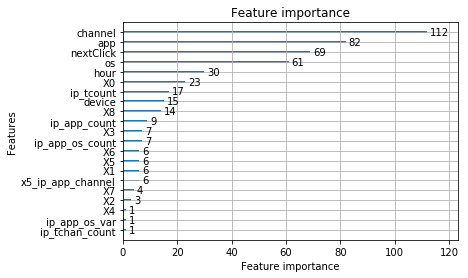

In [4]:
lgb.plot_importance(bst)